In [1]:
#checkpoint 1

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchani
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install --user bayesian-optimization


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)
    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)
    
    num_species = 4
    aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)



[notice] A new release of pip is available: 23.1.2 -> 25.1
[notice] To update, run: /global/software/rocky-8.x86_64/python-3.11.6/python-3.11.6/python/3.11.6-gcc/bin/python -m pip install --upgrade pip
cuda
384


In [2]:
def load_ani_dataset(dspath):
 self_energies = torch.tensor([
 0.500607632585, -37.8302333826,
 -54.5680045287, -75.0362229210
 ], dtype=torch.float, device=device)
 energy_shifter = torchani.utils.EnergyShifter(None)
 species_order = ['H', 'C', 'N', 'O']
 dataset = torchani.data.load(dspath)
 dataset = dataset.subtract_self_energies(energy_shifter, species_order)
 dataset = dataset.species_to_indices(species_order)
 dataset = dataset.shuffle()
 return dataset
dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [3]:
batch_size = 4096
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()


In [4]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(aev_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),

            nn.Linear(64, 52),
            nn.LeakyReLU(),


            nn.Linear(52, 24),
            nn.LeakyReLU(),
            
            
            nn.Linear(24, 8),
            nn.LeakyReLU(),
            nn.Linear(8,1)

        )

    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

train_data_batch = next(iter(train_data_loader))
loss_func = nn.MSELoss()
species = train_data_batch['species'].to(device)
coords = train_data_batch['coordinates'].to(device)
true_energies = train_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)


tensor(0.0491, device='cuda:0', grad_fn=<MseLossBackward0>)


In [5]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch 
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        print("Initialize training data...")
        train_data_loader = train_data.collate(self.batch_size).cache()
     
        loss_func = nn.MSELoss()
        
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                species = train_data_batch['species'].to(next(self.model.parameters()).device)
                coordinates = train_data_batch['coordinates'].to(next(self.model.parameters()).device)
                true_energies = train_data_batch['energies'].to(next(self.model.parameters()).device).float()
                _, pred_energies = self.model((species, coordinates))
                
                batch_loss = loss_func(pred_energies, true_energies)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_importance
            
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            train_loss_list.append(train_epoch_loss / len(train_data))
            val_loss_list.append(val_epoch_loss / len(val_data))
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(1, self.epoch+1), train_loss_list, label='Train')
            ax.plot(range(1, self.epoch+1), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(self.batch_size).cache()
        
        # we will accumulate sum of squared errors (SSE)
        loss_func = nn.MSELoss(reduction='sum')
        total_sse = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
            
                species = batch_data['species'].to(next(self.model.parameters()).device)
                coordinates = batch_data['coordinates'].to(next(self.model.parameters()).device)
                true_energies = batch_data['energies'].to(next(self.model.parameters()).device).float()
                _, pred_energies = self.model((species, coordinates))
                
                # sum of squared errors for this batch
                batch_sse = loss_func(pred_energies, true_energies)
                total_sse += batch_sse.item()
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        # compute MSE and then RMSE (in Hartree)
        n = len(data)
        mse  = total_sse / n
        rmse = np.sqrt(mse)
        
        if draw_plot:
            # convert to kcal/mol for plotting
            hartree2kcalmol = 627.5094738898777
            true_kcal = np.concatenate(true_energies_all) * hartree2kcalmol
            pred_kcal = np.concatenate(pred_energies_all) * hartree2kcalmol
            rmse_kcal = rmse * hartree2kcalmol

            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_kcal, pred_kcal, 
                       label=f"RMSE: {rmse_kcal:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth (kcal/mol)")
            ax.set_ylabel("Predicted (kcal/mol)")
            xmin, xmax = min(true_kcal.min(), pred_kcal.min()), max(true_kcal.max(), pred_kcal.max())
            ax.plot([xmin, xmax], [xmin, xmax], color='red', linewidth=1)
            ax.legend()
        
        return rmse



|   iter    |  target   | batch_... |  l2_reg   | learni... |
-------------------------------------------------------------
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [01:58<00:00,  7.92s/it]


[BO] bs=2048, lr=7.3e-05, l2=9.5e-05 → val_RMSE=2.6491e-04
| 1         | -0.000264 | 1.998e+03 | 9.512e-05 | 7.347e-05 |
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [01:47<00:00,  7.17s/it]


[BO] bs=3072, lr=1.6e-05, l2=1.6e-05 → val_RMSE=7.3455e-04
| 2         | -0.000734 | 3.117e+03 | 1.645e-05 | 1.644e-05 |
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [05:58<00:00, 23.90s/it]


[BO] bs=384, lr=6.1e-05, l2=8.7e-05 → val_RMSE=2.9207e-04
| 3         | -0.000292 | 418.0     | 8.675e-05 | 6.051e-05 |
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [01:58<00:00,  7.89s/it]


[BO] bs=2048, lr=3.0e-05, l2=7.6e-05 → val_RMSE=5.5809e-04
| 4         | -0.000558 | 1.999e+03 | 7.593e-05 | 3.021e-05 |
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [01:57<00:00,  7.84s/it]


[BO] bs=2048, lr=1.9e-05, l2=8.2e-05 → val_RMSE=6.6184e-04
| 5         | -0.000661 | 1.997e+03 | 8.172e-05 | 1.901e-05 |
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [02:03<00:00,  8.25s/it]


[BO] bs=1792, lr=1.5e-05, l2=4.8e-05 → val_RMSE=6.2539e-04
| 6         | -0.000625 | 1.752e+03 | 4.843e-05 | 1.514e-05 |

=== Best hyperparameters ===
batch_size    = 2048
learning_rate = 7.3e-05
l2_reg        = 9.5e-05
val_RMSE      = 2.6491e-04
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 50/50 [06:29<00:00,  7.79s/it]


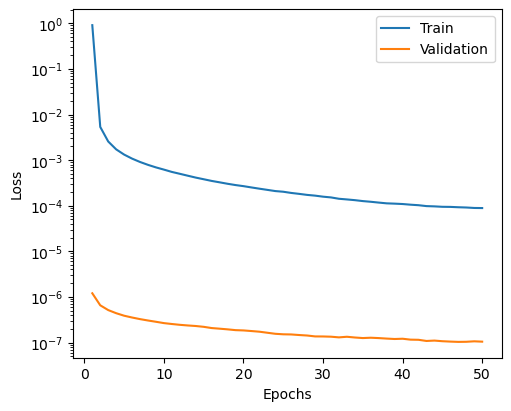

In [6]:
# CHECKPOINT 3 START 

# could randomly search 3 sets and return one with lowest error
# try bayesian opt to do it more elegantly

from bayes_opt import BayesianOptimization 
import numpy as np

num_epochs = 15

def bo_evaluate(batch_size, learning_rate, l2_reg):
    bs = int(np.round(batch_size / 128)) * 128
    bs = max(128, min(bs, 5120))
    lr = float(learning_rate)
    l2 = float(l2_reg)
    net_H = AtomicNet()
    net_C = AtomicNet()
    net_N = AtomicNet()
    net_O = AtomicNet()
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model   = nn.Sequential(aev_computer, ani_net).to(device)

    trainer = ANITrainer(
        model,
        batch_size     = bs,
        learning_rate  = lr,
        epoch          = num_epochs,
        l2             = l2
    )
    _, val_losses = trainer.train(
        train_data,
        val_data,
        early_stop = True,
        draw_curve = False
    )


    val_mse  = val_losses[-1]
    val_rmse = np.sqrt(val_mse)
    print(f"[BO] bs={bs}, lr={lr:.1e}, l2={l2:.1e} → val_RMSE={val_rmse:.4e}")
    return -val_rmse

pbounds = {
    'batch_size'    : (512,   5120),
    'learning_rate' : (1e-6,  1e-4),
    'l2_reg'        : (1e-6,  1e-4),
}

optimizer = BayesianOptimization(
    f            = bo_evaluate,
    pbounds      = pbounds,
    random_state = 42,
)

optimizer.maximize(init_points=3, n_iter=3)
best = optimizer.max['params']
best_bs  = int(np.round(best['batch_size'] / 128)) * 128
best_lr  = best['learning_rate']
best_l2  = best['l2_reg']
best_rmse = -optimizer.max['target']

print("\n=== Best hyperparameters ===")
print(f"batch_size    = {best_bs}")
print(f"learning_rate = {best_lr:.1e}")
print(f"l2_reg        = {best_l2:.1e}")
print(f"val_RMSE      = {best_rmse:.4e}")

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model   = nn.Sequential(aev_computer, ani_net).to(device)

trainer = ANITrainer(
    model,
    batch_size = best_bs,
    learning_rate = best_lr,
    epoch = 50,
    l2 = best_l2
)
train_losses, val_losses = trainer.train(
    train_data,
    val_data,
    early_stop = True,
    draw_curve = True
)

# CHECKPOINT 3 END


In [ ]:
#CHECKPOINT 4 START

from sklearn.model_selection import KFold
import numpy as np
import torch
from torch.utils.data import Subset

HARTREE2KCAL = 627.5094738898777
best_bs     = 512*2
best_lr     = 1e-3
best_l2     = 1e-5
num_epochs  = 15

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_val_rmses = []
indices = np.arange(len(dataset))

for fold, (train_idx, val_idx) in enumerate(kf.split(indices), start=1):
    print(f"Fold {fold} / {kf.n_splits}")
    # make subsets and carry over collate
    train_subset = Subset(dataset, train_idx.tolist())
    val_subset   = Subset(dataset, val_idx.tolist())
    train_subset.collate = dataset.collate
    val_subset.collate   = dataset.collate

    # fresh model
    net_H   = AtomicNet()
    net_C   = AtomicNet()
    net_N   = AtomicNet()
    net_O   = AtomicNet()
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model   = nn.Sequential(aev_computer, ani_net).to(device)

    trainer = ANITrainer(
        model,
        batch_size    = best_bs,
        learning_rate = best_lr,
        epoch         = num_epochs,
        l2            = best_l2
    )
    _, val_losses = trainer.train(
        train_subset,
        val_subset,
        early_stop = True,
        draw_curve = False
    )

    # compute mean MSE and then RMSE in Hartree
    mean_mse_hartree = val_losses[-1] / len(val_subset)
    rmse_hartree     = np.sqrt(mean_mse_hartree)
    # convert to kcal/mol
    rmse_kcal = rmse_hartree * HARTREE2KCAL

    print(f"Fold {fold} average val_RMSE = {rmse_hartree:.4e} Hartree  "
          f"= {rmse_kcal:.2f} kcal/mol")
    all_val_rmses.append(rmse_kcal)

mean_rmse = np.mean(all_val_rmses)
std_rmse  = np.std(all_val_rmses)
print(f"5-fold CV mean val_RMSE = {mean_rmse:.2f} ± {std_rmse:.2f} kcal/mol")

# CHECKPOINT 4 END


=== Fold 1 / 5 ===
Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [09:14<00:00, 36.97s/it]


Fold 1 average val_RMSE = 6.5488e-07

=== Fold 2 / 5 ===
Sequential - Number of parameters: 317172
Initialize training data...


 60%|██████    | 9/15 [05:33<03:41, 36.99s/it]

Sequential - Number of parameters: 317172
Initialize training data...


100%|██████████| 15/15 [02:46<00:00, 11.07s/it]


0.0070561233680136864

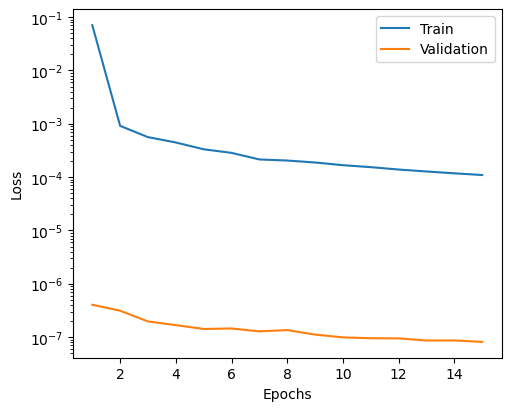

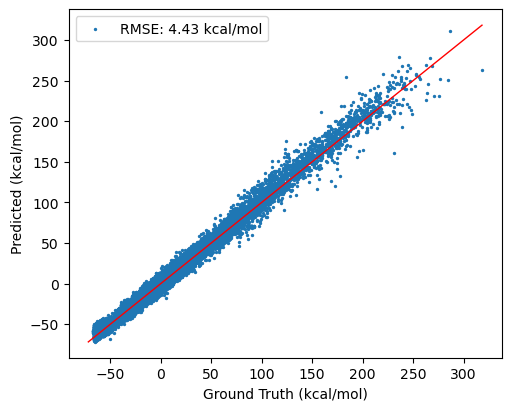

In [10]:
#CHECKPOINT 5 START
# evaluate
# val curves
# also plot BO RSME over iterations to show it works

best_bs = 512*2
best_lr = 1e-3
best_l2 = 1e-5
num_epochs = 15


net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model   = nn.Sequential(aev_computer, ani_net).to(device)

trainer = ANITrainer(
    model,
    batch_size = best_bs,
    learning_rate = best_lr,
    epoch = num_epochs,
    l2 = best_l2
)

train_losses, val_losses = trainer.train(
    train_data,
    val_data,
    early_stop = True,
    draw_curve = True
)

trainer.evaluate(val_data, draw_plot=True)



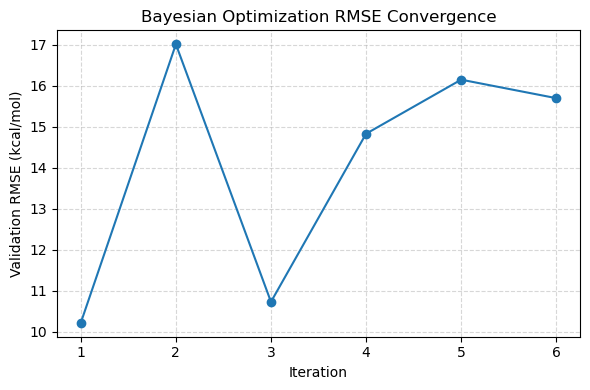

In [4]:

import numpy as np
import matplotlib.pyplot as plt

val_MSEs = [
    2.6491e-04, 7.3455e-04, 2.9207e-04,
    5.5809e-04, 6.6184e-04, 6.2539e-04
]
HARTREE2KCAL = 627.5094738898777

rmse_per_iter_hartree = np.sqrt(val_MSEs)
rmse_per_iter_kcal    = rmse_per_iter_hartree * HARTREE2KCAL
iters = np.arange(1, len(rmse_per_iter_kcal) + 1)

plt.figure(figsize=(6,4))
plt.plot(iters, rmse_per_iter_kcal, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Validation RMSE (kcal/mol)")
plt.title("Bayesian Optimization RMSE Convergence")
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()
